In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [4]:
y = y.astype(int)
X = X / 255
X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]

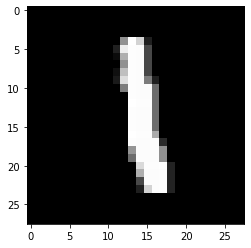

In [5]:
sample = X_train[6]
sample_img = sample.reshape(28, 28)
plt.imshow(sample_img, cmap='gray')

In [13]:
#X_train = X_train.reshape(-1, 28, 28)
#X_test = X_test.reshape(-1, 28, 28)

In [6]:
X_train.shape

(60000, 784)

In [27]:
label, val = np.unique(y_train, return_counts=True)
val

array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

<BarContainer object of 10 artists>

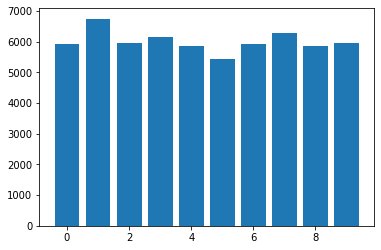

In [9]:
plt.bar(x=label, height=val)

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()


In [11]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [12]:
knn_clf.predict([sample])

array([1])

In [16]:
y_test_pred = knn_clf.predict(X_test)

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

In [15]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_train_pred)

0.9674166666666667

In [17]:
accuracy_score(y_test, y_test_pred)

0.9688

In [19]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5882,    4,    5,    0,    1,    5,   19,    1,    2,    4],
       [   2, 6705,   10,    2,    1,    1,    3,   11,    2,    5],
       [  51,   60, 5695,   15,   11,    4,    9,   87,   17,    9],
       [   8,   16,   39, 5903,    1,   63,    4,   40,   33,   24],
       [   3,   53,    1,    1, 5628,    0,   13,   11,    2,  130],
       [  14,   18,    4,   67,    6, 5211,   58,    7,   11,   25],
       [  24,   13,    1,    0,    5,   27, 5846,    0,    2,    0],
       [   4,   68,   14,    3,   20,    1,    0, 6083,    3,   69],
       [  25,   85,   15,   87,   35,  111,   26,   19, 5382,   66],
       [  19,   13,    5,   45,   46,   12,    5,   79,   15, 5710]])

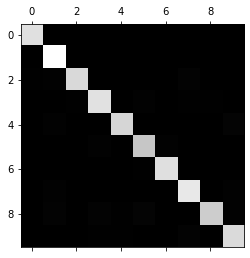

In [22]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [23]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

<Figure size 1440x1440 with 0 Axes>

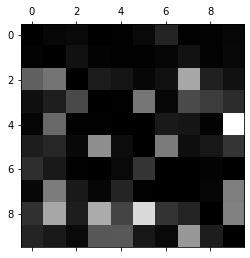

In [35]:
np.fill_diagonal(norm_conf_mx, 0)
plt.figure(figsize=(20, 20))
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [31]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
    {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}
  ]

grid_search = RandomizedSearchCV(knn_clf, param_grid, n_iter=5, refit=True)

grid_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=KNeighborsClassifier(), n_iter=5,
                   param_distributions=[{'n_neighbors': [3, 5, 10],
                                         'weights': ['uniform', 'distance']}])

In [115]:
grid_search.best_params_

{'weights': 'distance', 'n_neighbors': 5}

In [33]:
grid_search.best_score_

0.9704166666666667

In [36]:
y_test_pred = knn_clf.predict(X_test)

In [38]:
accuracy_score(y_test, y_test_pred)

0.9688

Cross validation and Grid Search didn't really improve the classification accuracy score on the test set. 

Let's see which are the results that are getting falsely classified

In [39]:
conf_mx = confusion_matrix(y_test, y_test_pred)

In [40]:
conf_mx

array([[ 974,    1,    1,    0,    0,    1,    2,    1,    0,    0],
       [   0, 1133,    2,    0,    0,    0,    0,    0,    0,    0],
       [  11,    8,  991,    2,    1,    0,    1,   15,    3,    0],
       [   0,    3,    3,  976,    1,   13,    1,    6,    3,    4],
       [   3,    7,    0,    0,  944,    0,    4,    2,    1,   21],
       [   5,    0,    0,   12,    2,  862,    4,    1,    2,    4],
       [   5,    3,    0,    0,    3,    2,  945,    0,    0,    0],
       [   0,   22,    4,    0,    3,    0,    0,  988,    0,   11],
       [   8,    3,    5,   13,    6,   12,    5,    5,  913,    4],
       [   5,    7,    3,    9,    7,    3,    1,   10,    2,  962]])

It seems like the issue is with mainly between the numbers 1, 7 and 9 

Lets try to create more data (data augmentation) to see if that will improve the score

The way we are going to create more data is by rotating the images by 10deg on both - right and left sides

In [74]:
from scipy.ndimage.interpolation import rotate

def img_augmenter(img) -> list:
    img = img.reshape(28, 28)
    rot_img_left = rotate(img, angle=10, reshape=False)
    rot_img_right = rotate(img, angle=-10, reshape=False)
    rot_img_left = rot_img_left.reshape(1, -1)
    rot_img_right = rot_img_right.reshape(1, -1)

    return [rot_img_left, rot_img_right]


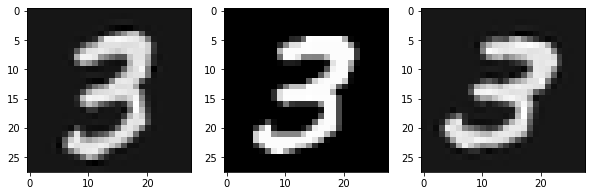

In [80]:
# Check for a sample image

sample_img = X_train[7]
sample_out_left, sample_out_right = tuple(img_augmenter(sample_img))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))

#sample_out_left.shape
img_left = sample_out_left.reshape(28, 28)
ax[0].imshow(img_left, cmap='gray')

original_img = sample_img.reshape(28, 28)
ax[1].imshow(original_img, cmap='gray')

img_right = sample_out_right.reshape(28, 28)
ax[2].imshow(img_right, cmap='gray')



If you carefully notice, the left and right rotated images (new images) are slightly less in contrast compared to
original image. This may be the effect of aliasing due to rotation. Let's ignore this issue and go ahead for now.

In [95]:
new_data = list()
new_labels = list()

for i, img in enumerate(X_train):
    label = y_train[i]
    new_data.extend(img_augmenter(img))
    new_labels.extend([label] * 2)
    
new_data = np.asarray(new_data)
new_labels = np.asarray(new_labels)

print(new_data.shape)
print(new_labels.shape)

(120000, 1, 784)
(120000,)


3

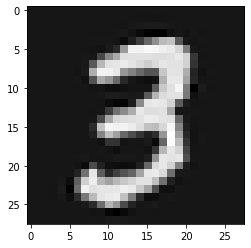

In [102]:
new_data = new_data.reshape(-1, 784)

sample = 14

img = new_data[sample].reshape(28, 28)
plt.imshow(img, cmap='gray')

new_labels[sample]

In [106]:
new_data.shape

(120000, 784)

In [109]:
X_train = list(X_train)
X_train.extend(list(new_data))

In [111]:
X_train = np.asarray(X_train)


In [112]:
y_train = list(y_train)
y_train.extend(list(new_labels))

In [113]:
y_train = np.asarray(y_train)

In [114]:
y_train.shape

(180000,)

In [116]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [119]:
knn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [120]:
y_test_pred = knn_clf.predict(X_test)

accuracy_score(y_test, y_test_pred)

0.9763

We have achieved a good accuracy score of 97.63% using KNN classifier. 

Following points were understood - 
- Data Augmentation leads to improve in accuracy
- Hyperparameter tuning improves accuracy